In [14]:
import time
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import numpy as np
from PIL import Image
import torch.utils.data.dataset as datautil


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [15]:
# need to do this twice for it to work for some reason
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Load preprocessed dataset mean and standard deviation 

Text(0.5,1,'Std image')

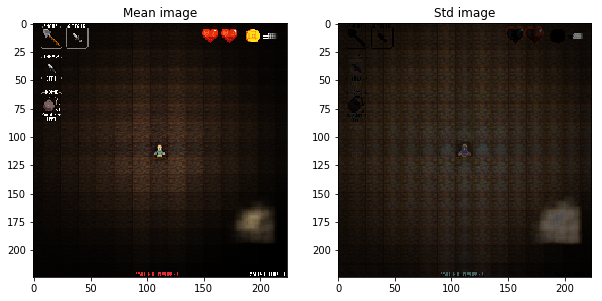

In [16]:
dset_mean = np.load("data/stats/dsetMean_ResNet.npy")
dset_std = np.load("data/stats/dsetStd_ResNet.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

Pytorch expects the data shape to be CxHxW (instead of the current HxWxC) so we reshape the mean and std image here, then use them to calculate the means for the three color channels. For images in the training data, this transposition is handled when the dataset object applies the ToTensor() transformation.

In [17]:
dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))
print(dset_mean.shape, dset_std.shape)

(3, 224, 224) (3, 224, 224)


Finally, calculate the mean and std over the three image channels.

In [18]:
channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

Per-channel means:
[0.108758   0.07287232 0.04886061]
Per-channel stds:
[0.12114082 0.09168397 0.07717402]


# Initialize dataset and data loader objects
Use the channel mean and std to define a normalization transform which our dataset object will apply to each of its images upon loading them.

In [19]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

usingQuad = True #using the 4 images in 1 or just individual images
earlyIntegration = True
using224Scaling = True

# dataset = datasets.DatasetFolder(root='data/classes/normalized', extensions=['npy'], loader=np.load, transform=image_transform)
if usingQuad:
    if using224Scaling:
        dataset = datasets.ImageFolder(root='data/classes/224scaledQuad', transform=image_transform)
    else:
        dataset = datasets.ImageFolder(root='data/classes/downscaledQuad', transform=image_transform)
else:
    if using224Scaling:
        dataset = datasets.ImageFolder(root='data/classes/224scaledIndiv', transform=image_transform)
    else:
        dataset = datasets.ImageFolder(root='data/classes/downscaledIndiv', transform=image_transform)
    
num_train = len(dataset)
print("Training set has {} examples.".format(num_train))


Training set has 12261 examples.


Split the full dataset into train and val randomly (seeded), then create data loader objects for each set.

In [20]:
num_val = num_train // 10
permutation = np.random.RandomState(seed=0).permutation(num_train)

val_dataset = datautil.Subset(dataset, permutation[:num_val])
train_dataset = datautil.Subset(dataset, permutation[num_val:])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           sampler=sampler.SubsetRandomSampler(range(num_train-num_val)))

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=64,
                                           sampler=sampler.SubsetRandomSampler(range(num_val)))

Show an image and its label from the training set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train image shape:  torch.Size([3, 224, 896])


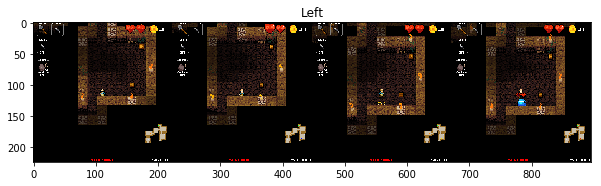

In [21]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Train image shape: ", images[0].shape)

# plt.imshow((images[0].numpy() * dset_std/255 + dset_mean/255).transpose(1,2,0))
plt.imshow((images[0].numpy() * channel_stds.reshape((3,1,1)) + channel_means.reshape((3,1,1))).transpose(1,2,0))

labelNames = {0:"Up",1:"Right",2:"Down",3:"Left"}
_ = plt.title(labelNames[labels[0].item()])

# Define training and validation functions

In [22]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [23]:
def check_model_accuracy(loader, model, name): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            if usingQuad:
                if using224Scaling:
                    split = (x[:,:,:,:224],x[:,:,:,224:448],x[:,:,:,448:672],x[:,:,:,672:896])
                else:
                    split = (x[:,:,:,:180],x[:,:,:,180:360],x[:,:,:,360:540],x[:,:,:,540:720])
                    
                if earlyIntegration:
                    scores = model(torch.cat(split, dim=1))
                else:
                    scores = model(split)
            else:
                scores = model(x)
            
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('%s set: Got %d / %d correct (%.2f)' % (name, num_correct, num_samples, 100 * acc))
    return acc

In [24]:
# Constant to control how frequently we check val loss
print_every = (num_train/64)//2 + 1 # 

def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_losses, train_accuracy, val_accuracy = [], [], []
    best_val = 0
    timestamp = time.strftime("%m_%d_T%H_%M") # time started training, best val model will be saved with this
    modelFile = None
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print('Epoch {}'.format(e))
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            if usingQuad:
                if using224Scaling:
                    split = (x[:,:,:,:224],x[:,:,:,224:448],x[:,:,:,448:672],x[:,:,:,672:896])
                else:
                    split = (x[:,:,:,:180],x[:,:,:,180:360],x[:,:,:,360:540],x[:,:,:,540:720])
                    
                if earlyIntegration:
                    scores = model(torch.cat(split, dim=1))
                else:
                    scores = model(split)
            else:
                scores = model(x)
            
            loss = F.cross_entropy(scores, y)
            train_losses.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                val = check_model_accuracy(val_loader, model, 'Val')
                if val > best_val:
                    # save the best model over the course of training
                    modelFile = 'models/cloningCNN_val{}_{}.pt'.format(int(val*100),timestamp)
                    torch.save(model.state_dict(), modelFile)
                    best_val = val
                if t == 0:
                    train_accuracy.append(check_model_accuracy(train_loader, model, 'Train'))
                    val_accuracy.append(val)
                print()
        
    return (train_losses, train_accuracy, val_accuracy, modelFile)

# Load model defined in cloningCNN.py

In [25]:
from cloningCNN import CloningCNN
from cloningCNN import MultiSequentialCNN
from cloningCNN import ResNet

#model = CloningCNN('deeper', dropout=0.5, inChannels=3)
# model = MultiSequentialCNN(netType='original', dropout=0) #this is drop probability
model = ResNet()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train on the dataset!

In [26]:
train_losses, train_accuracy, val_accuracy, modelFile = train_model(model, optimizer, epochs=9)

Epoch 0
Iteration 0, loss = 1.4232
Val set: Got 285 / 1226 correct (23.25)
Train set: Got 2378 / 11035 correct (21.55)

Iteration 96, loss = 0.9737
Val set: Got 586 / 1226 correct (47.80)

Epoch 1
Iteration 0, loss = 0.6655
Val set: Got 840 / 1226 correct (68.52)
Train set: Got 7554 / 11035 correct (68.45)

Iteration 96, loss = 0.8584
Val set: Got 891 / 1226 correct (72.68)

Epoch 2
Iteration 0, loss = 0.8062
Val set: Got 859 / 1226 correct (70.07)
Train set: Got 7861 / 11035 correct (71.24)

Iteration 96, loss = 0.7052
Val set: Got 932 / 1226 correct (76.02)

Epoch 3
Iteration 0, loss = 0.6115
Val set: Got 870 / 1226 correct (70.96)
Train set: Got 8092 / 11035 correct (73.33)

Iteration 96, loss = 0.3790
Val set: Got 946 / 1226 correct (77.16)

Epoch 4
Iteration 0, loss = 0.6474
Val set: Got 957 / 1226 correct (78.06)
Train set: Got 8953 / 11035 correct (81.13)

Iteration 96, loss = 0.4534
Val set: Got 944 / 1226 correct (77.00)

Epoch 5
Iteration 0, loss = 0.4392
Val set: Got 956 / 1

Loss and accuracy plots.

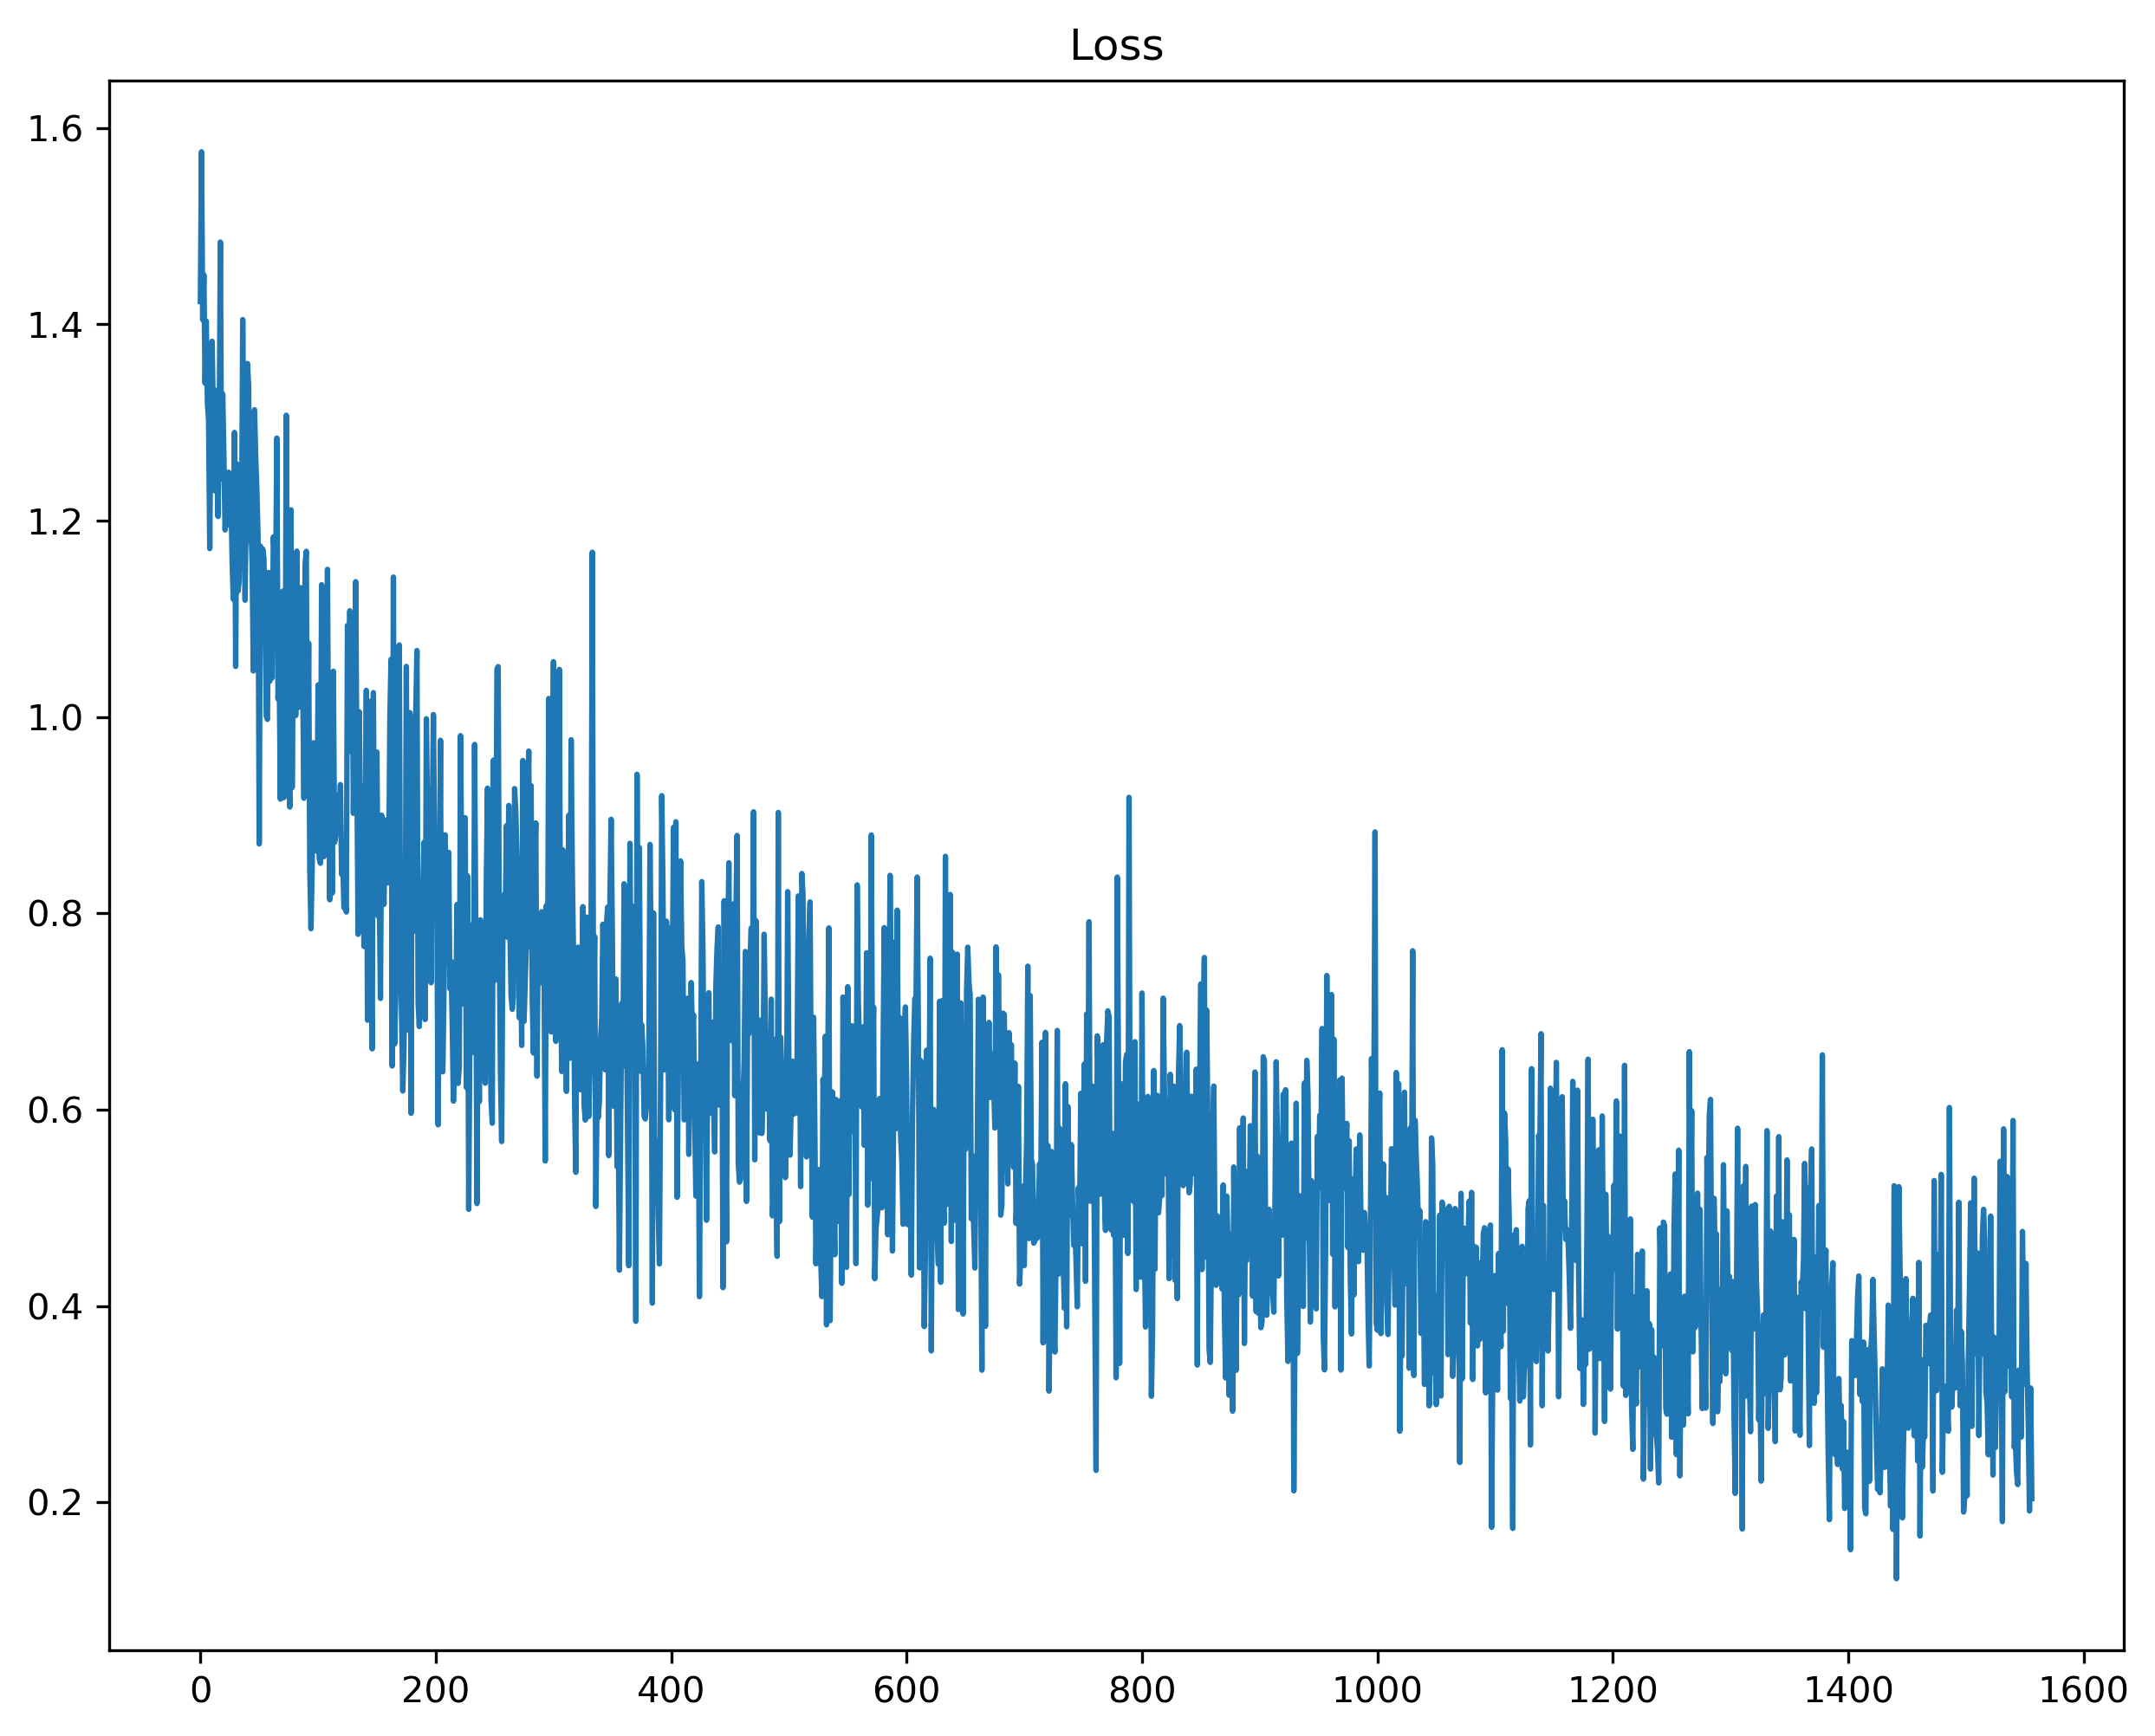

In [27]:
plt.figure(dpi=300)

plt.plot(train_losses)
plt.title("Loss")
plt.savefig('demos/BestResnetLoss2.png')
plt.show()

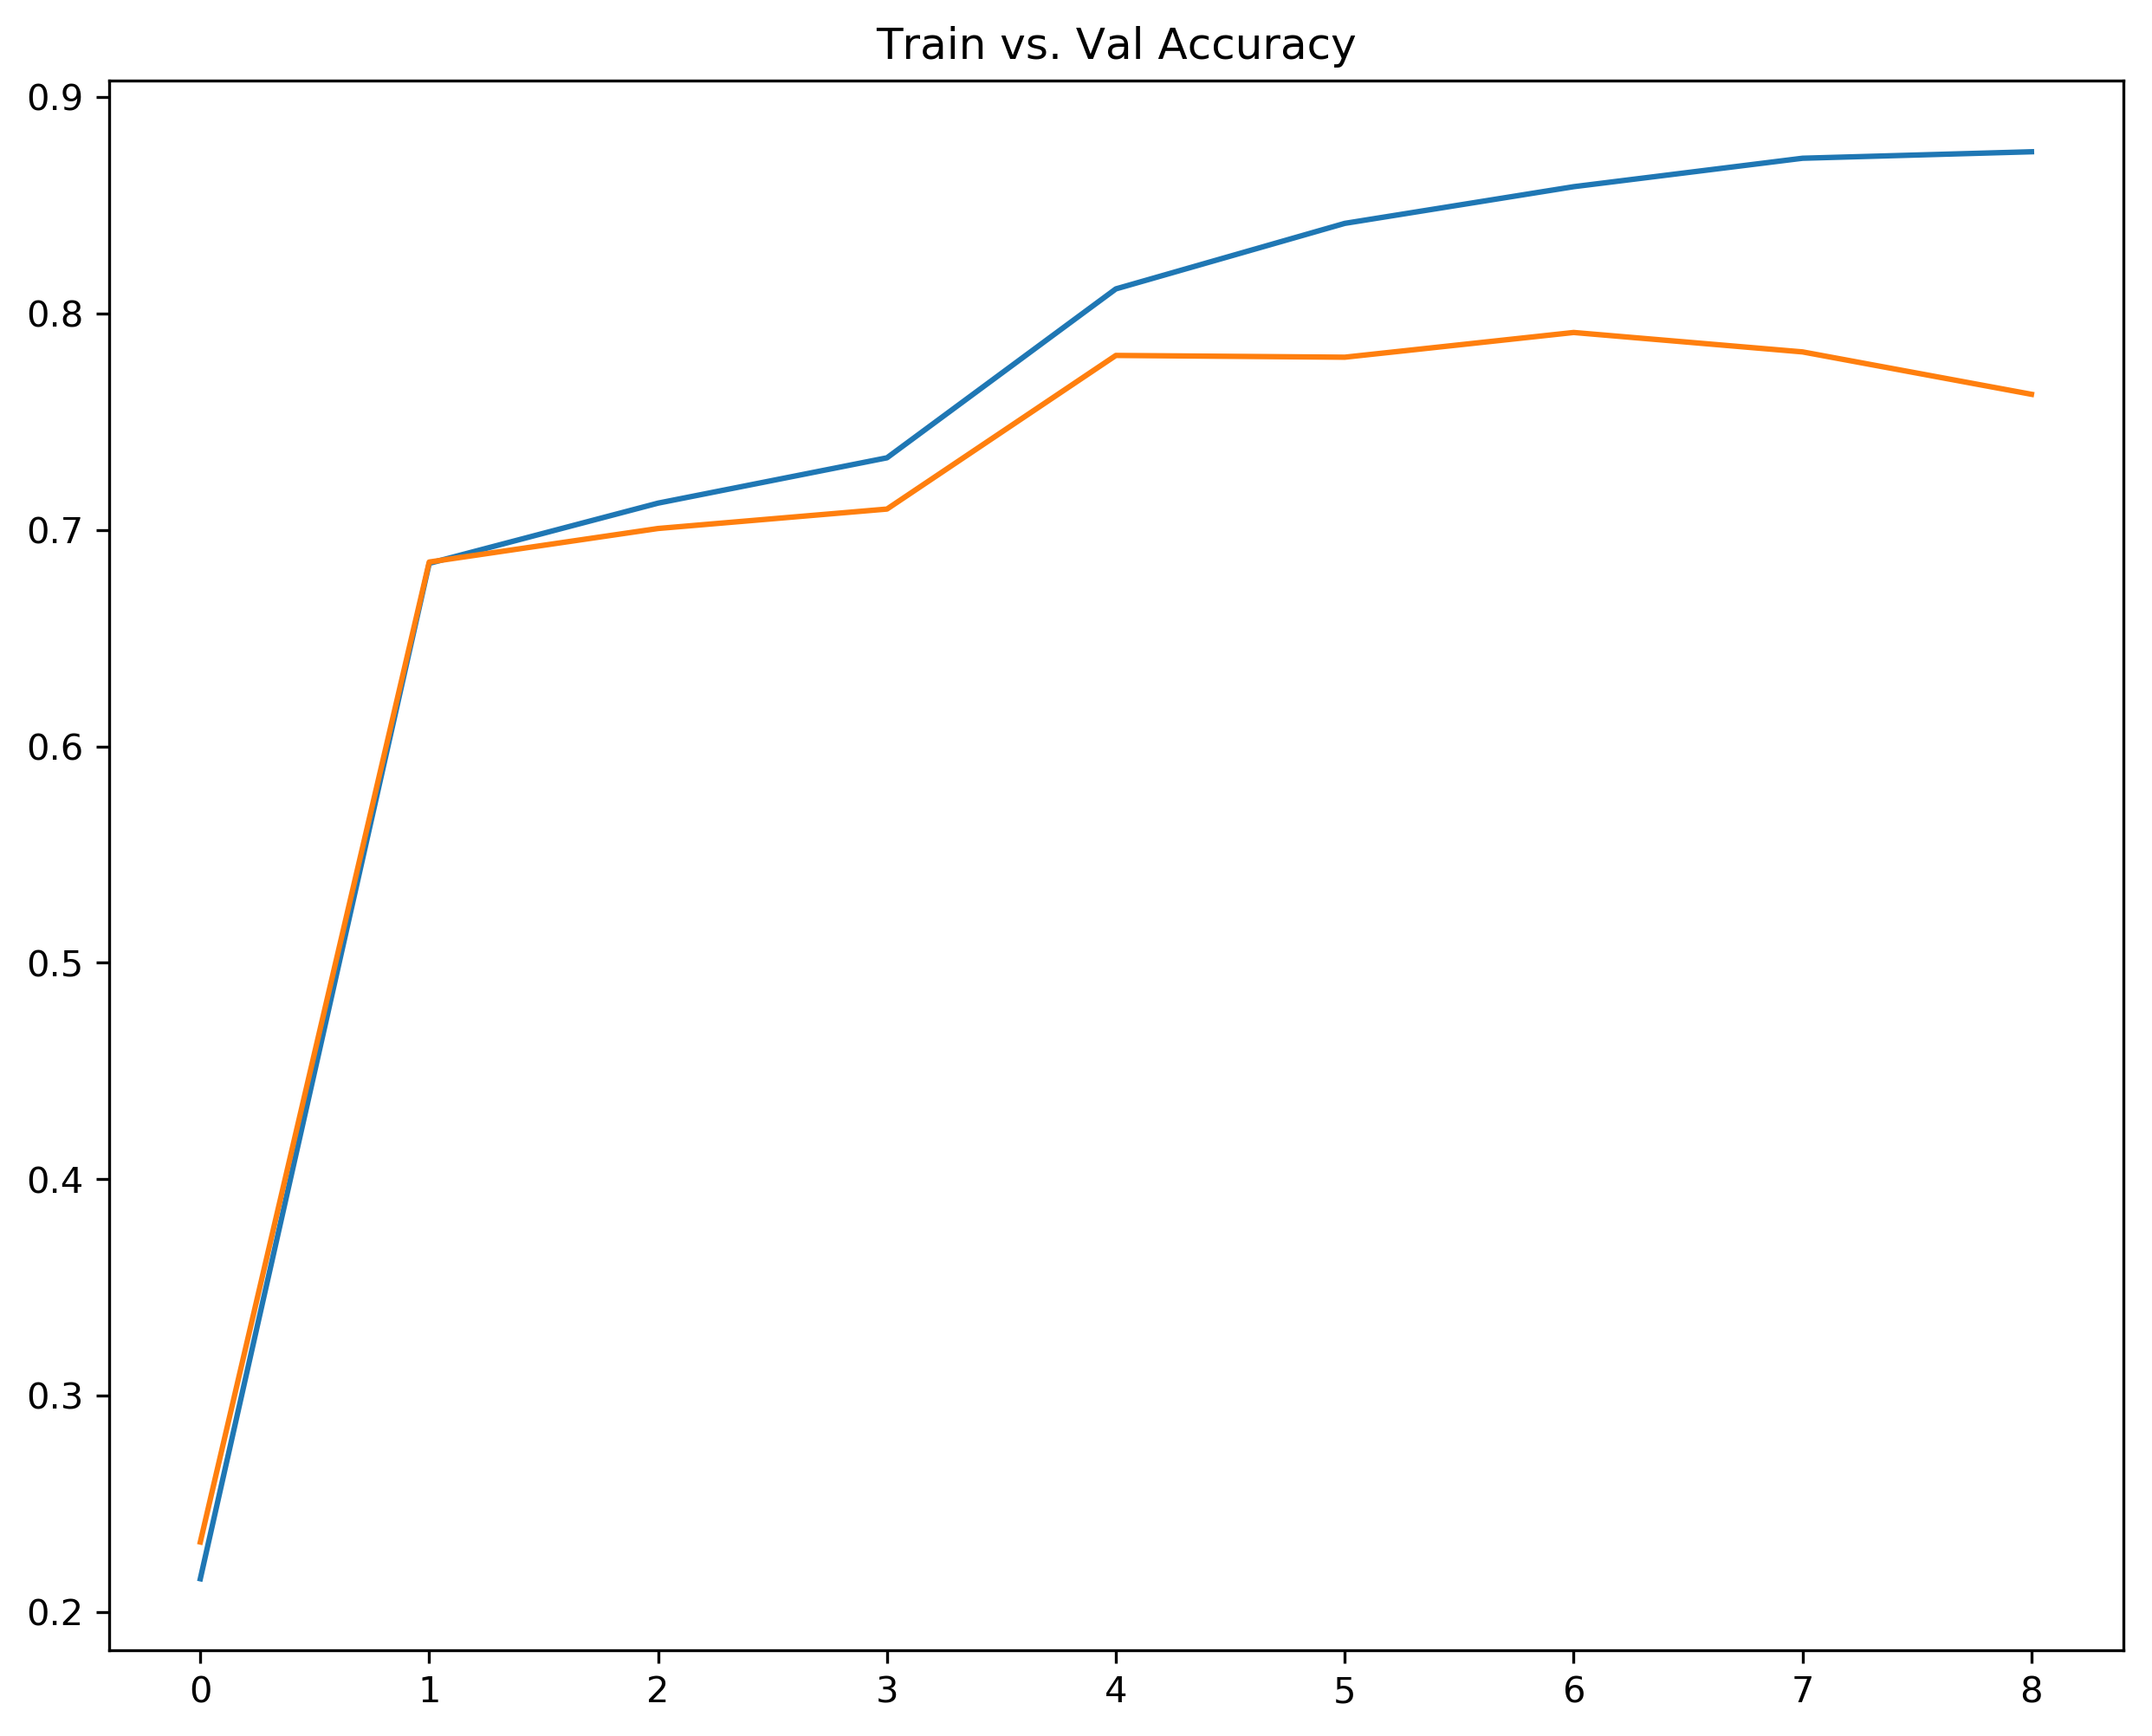

In [28]:
plt.figure(dpi=300)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title("Train vs. Val Accuracy")
plt.savefig('demos/BestResnetAccuracy2.png')
plt.show()

Check that the best model saved correctly.

In [29]:
model.load_state_dict(torch.load(modelFile))

In [30]:
check_model_accuracy(val_loader, model, 'Val')

Val set: Got 970 / 1226 correct (79.12)


0.7911908646003263